In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import hdbscan
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import re
import contractions

nltk.download("stopwords")
nltk.download("wordnet")

/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/visheshgupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/visheshgupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
gold_df = pd.read_csv("gold-dataset-sinha-khandait.csv")
headlines_data = np.array(gold_df["News"])

In [3]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


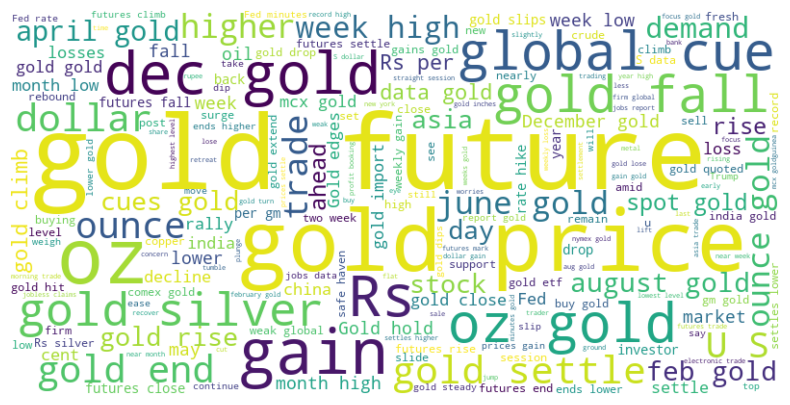

In [ ]:
def generate_wordcloud(cluster_df, column="News"):
    text = " ".join(cluster_df[column].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        text
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


generate_wordcloud(gold_df)

In [ ]:
def clean_text(text):
    # Expand contractions (e.g., "don't" → "do not")
    text = contractions.fix(text)

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove special chars, punctuation
    text = re.sub(r"[^\w\s\']", "", text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = " ".join(text.split())

    return text

In [ ]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

In [ ]:
gold_df["cleaned_News"] = gold_df["News"].apply(clean_text)
gold_df["lemmatized_News"] = gold_df["cleaned_News"].apply(lemmatize_text)

stop_words = set(stopwords.words("english"))
gold_df["final_News"] = gold_df["lemmatized_News"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)

In [8]:
headlines_data

array(['april gold down 20 cents to settle at $1,116.10/oz',
       'gold suffers third straight daily decline',
       'Gold futures edge up after two-session decline', ...,
       'Gold heading for worst week since November on rate hike worries',
       'august gold up $7.60 at $878.80 an ounce on nymex',
       'december gold down $1 at $749 an ounce on nymex'], dtype=object)

In [9]:
gold_df["final_News"]

0                      april gold 20 cent settle 111610 oz
1                 gold suffer third straight daily decline
2                      gold future edge twosession decline
3                  dent research gold 's day sun come soon
4        gold snap threeday rally trump lawmaker reach ...
                               ...                        
10565                        gold see fall 3week high week
10566    dominic frisby look like good time buy gold ne...
10567    gold head bad week since november rate hike worry
10568                    august gold 760 87880 ounce nymex
10569                      december gold 1 749 ounce nymex
Name: final_News, Length: 10570, dtype: object

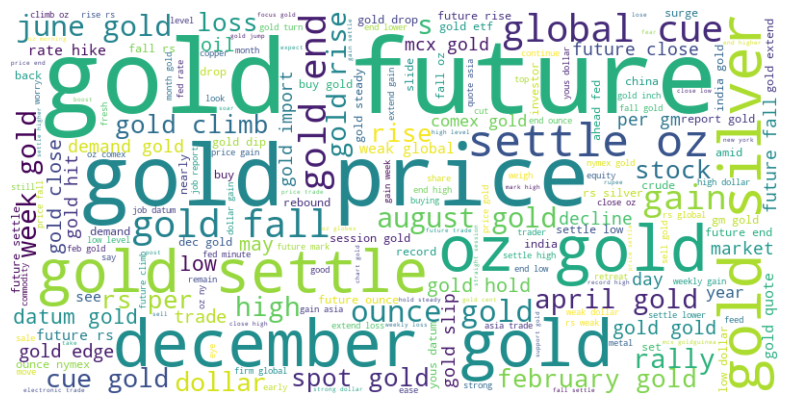

In [ ]:
generate_wordcloud(gold_df, "final_News")

In [ ]:
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = tfidf.fit_transform(gold_df["final_News"])

In [12]:
X_tfidf.shape

(10570, 5000)

# K Means

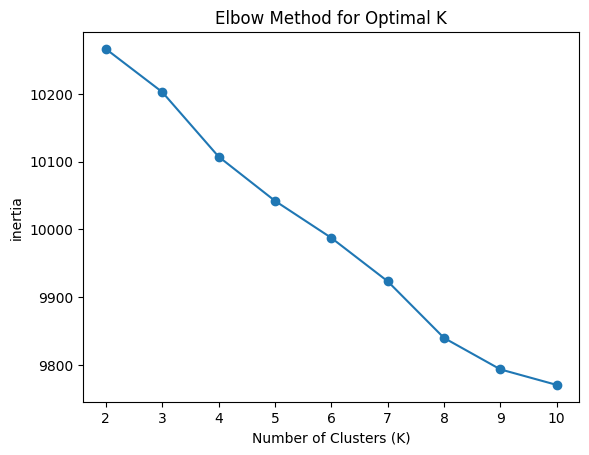

In [ ]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

In [24]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_tfidf)

# Evaluate
silhouette = silhouette_score(X_tfidf, clusters_kmeans)
print(f"Silhouette Score (K-Means): {silhouette:.2f}")

Silhouette Score (K-Means): 0.02


/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


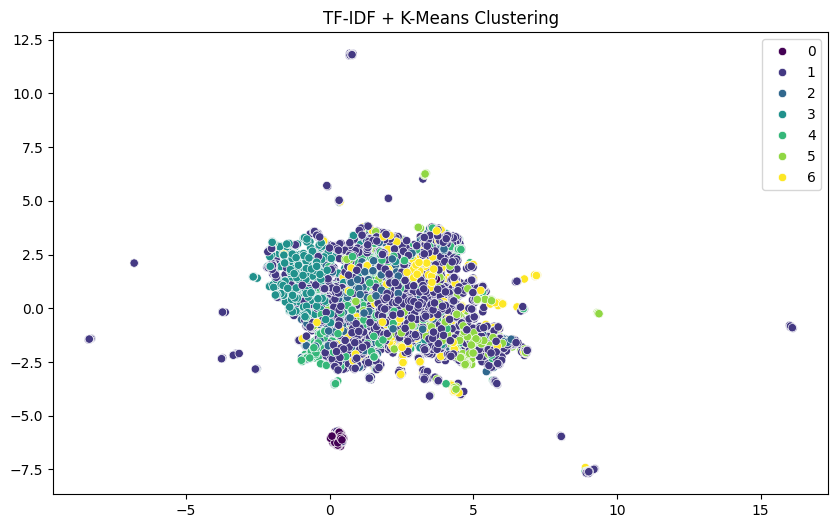

In [ ]:
# really poor n_clusters above
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters_kmeans, palette="viridis")
plt.title("TF-IDF + K-Means Clustering")
plt.show()

## DBSCAN

In [26]:
# redcue dimensions

reducer = umap.UMAP(n_components=20, random_state=42)
X_umap_tfidf = reducer.fit_transform(X_tfidf.toarray())

/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [27]:
X_umap_tfidf.shape

(10570, 20)

Best Parameters: {'eps': 1.0, 'min_samples': 10}
Best Silhouette Score: 0.15
Number of Clusters: 14
Noise Points: 9


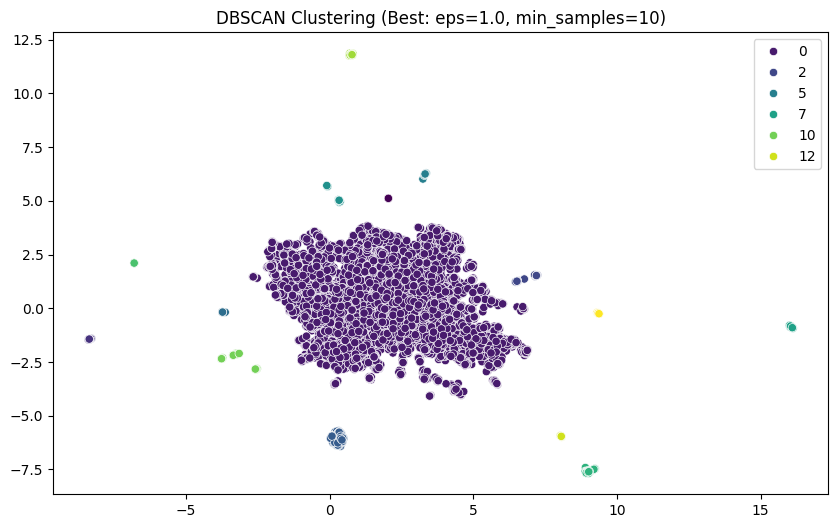

In [ ]:
from itertools import product

from sklearn.cluster import DBSCAN


eps_values = [0.3, 0.5, 0.7, 1.0]  # Test these ranges
min_samples_values = [3, 5, 10]  # Adjust based on expected cluster size

best_score = -1
best_params = {"eps": None, "min_samples": None}
best_clusters = None

# Grid Search
for eps, min_samples in product(eps_values, min_samples_values):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_umap)

    # Skip if all points are noise or only 1 cluster
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    if n_clusters < 2:
        continue

    # Calculate Silhouette Score (ignore noise points)
    mask = clusters != -1
    if sum(mask) > 0:  # Only compute if non-noise points exist
        score = silhouette_score(X_umap[mask], clusters[mask])
    else:
        continue

    # Update best parameters
    if score > best_score:
        best_score = score
        best_params = {"eps": eps, "min_samples": min_samples}
        best_clusters = clusters

# Results
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score:.2f}")
print(
    f"Number of Clusters: {len(set(best_clusters)) - (1 if -1 in best_clusters else 0)}"
)
print(f"Noise Points: {sum(best_clusters == -1)}")

# Visualize the best clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=best_clusters, palette="viridis")
plt.title(
    f"DBSCAN Clustering (Best: eps={best_params['eps']}, min_samples={best_params['min_samples']})"
)
plt.show()

In [34]:
gold_df["cluster"] = best_clusters


=== Noise/Outliers ===

Sample Headlines:
- moody's revises pilgrim's pride outlook on gold kist bid
- gold kist rejects pilgrim's pride offer as inadequate
- pilgrim's pride to acquire gold kist for $21 a share
- pilgrim's pride extends gold kist tender offer
- pilgrim's pride to launch gold kist tender at $20 a share

Top 10 Terms:
- pride (count: 9)
- gold (count: 9)
- kist (count: 9)
- offer (count: 3)
- bid (count: 2)
- share (count: 2)
- tender (count: 2)
- takeover (count: 2)
- revises (count: 1)
- outlook (count: 1)


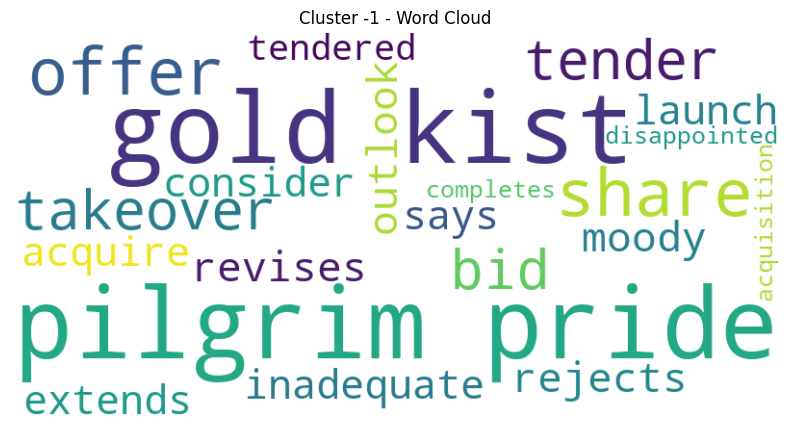


=== Cluster 0 (Size: 9931) ===

Sample Headlines:
- april gold down 20 cents to settle at $1,116.10/oz
- gold suffers third straight daily decline
- Gold futures edge up after two-session decline
- dent research : is gold's day in the sun coming soon?
- Gold snaps three-day rally as Trump, lawmakers reach debt-ceiling deal

Top 10 Terms:
- gold (count: 9362)
- futures (count: 1555)
- prices (count: 1021)
- for (count: 848)
- after (count: 833)
- down (count: 781)
- dollar (count: 682)
- silver (count: 681)
- the (count: 680)
- gains (count: 560)


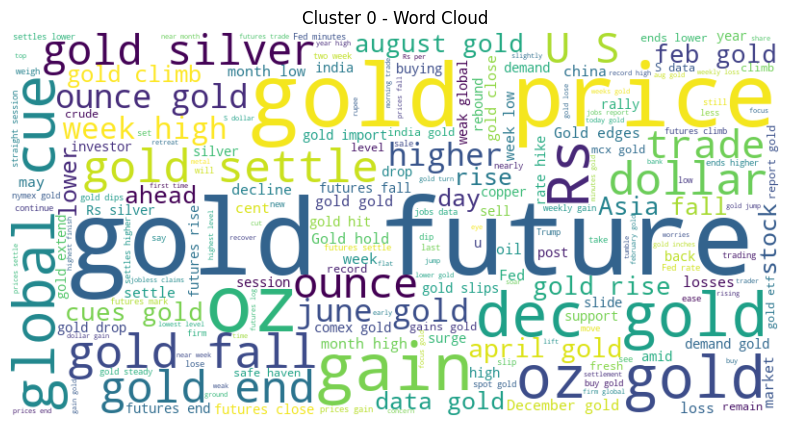


=== Cluster 1 (Size: 40) ===

Sample Headlines:
- gold to trade in 28670-29160 range: achiievers equities
- gold to trade in 28372-28686 range: achiievers equities
- gold to trade in 27287-27713 range: achiievers equities
- gold to trade in 28812-29204: achiievers equities
- gold to trade in 29646-30122 range: achiievers equities

Top 10 Terms:
- gold (count: 40)
- trade (count: 37)
- equities (count: 37)
- achiievers (count: 36)
- range (count: 2)
- trades (count: 1)
- under (count: 1)
- rise (count: 1)
- will (count: 1)
- keep (count: 1)


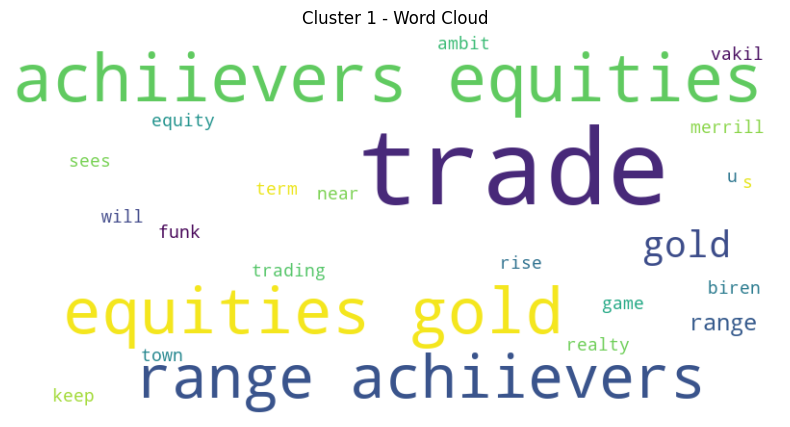


=== Cluster 2 (Size: 34) ===

Sample Headlines:
- gold prices gain in major metros in india
- Gold prices trading higher in Chennai, Ahmedabad market
- Gain seen in gold prices in Mumbai, Delhi market
- gold rates slip in major cites india
- Spot Gold rates slip in Jaipur, Ahmd, Chennai market

Top 10 Terms:
- gold (count: 34)
- major (count: 20)
- prices (count: 19)
- india (count: 16)
- metros (count: 15)
- market (count: 12)
- rates (count: 11)
- trading (count: 10)
- spot (count: 8)
- slip (count: 7)


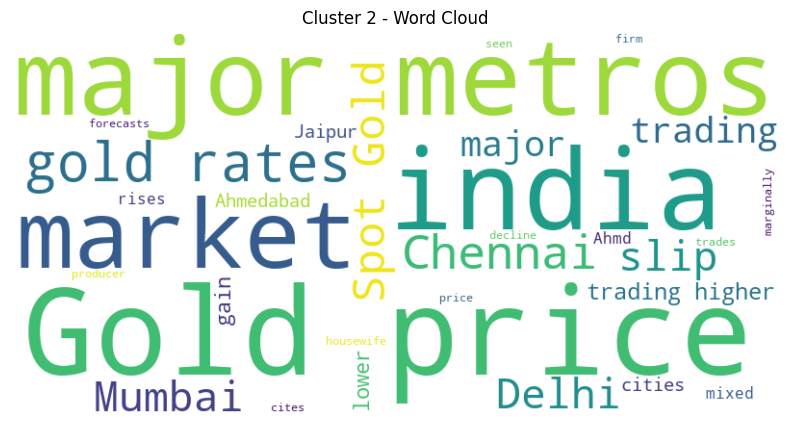


=== Cluster 3 (Size: 169) ===

Sample Headlines:
- gold rates: mcx goldguinea july contract declines
- MCX GOLD February contract moves up
- MCX GOLDPETAL Nov contract up marginally
- mcx goldguinea november contract rises
- MCX GOLD Dec contract trading lower

Top 10 Terms:
- contract (count: 163)
- mcx (count: 161)
- gold (count: 61)
- goldguinea (count: 46)
- goldpetal (count: 38)
- trades (count: 35)
- goldm (count: 29)
- gains (count: 24)
- lower (count: 23)
- trading (count: 19)


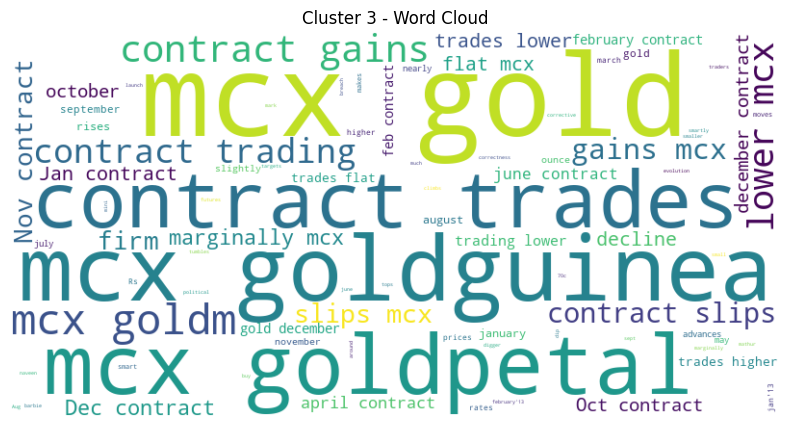


=== Cluster 4 (Size: 15) ===

Sample Headlines:
- gold shares buoy bay street
- gold, energy lead bay street rally
- gold stocks jump-start bay street
- gold, nortel weigh on bay street
- nortel, gold buoy bay street

Top 10 Terms:
- bay (count: 13)
- street (count: 13)
- gold (count: 10)
- energy (count: 4)
- shares (count: 2)
- buoy (count: 2)
- stocks (count: 2)
- weigh (count: 2)
- and (count: 2)
- lead (count: 1)


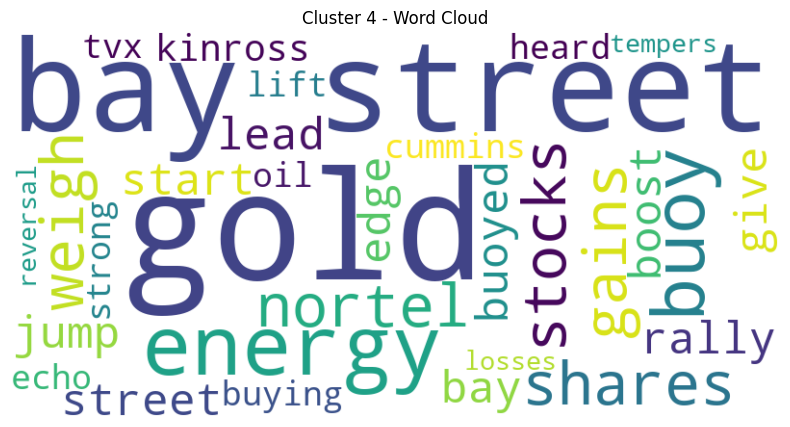


=== Cluster 5 (Size: 30) ===

Sample Headlines:
- Gold / Silver / Copper futures - weekly outlook: August 4 - 8
- Gold / Silver / Copper futures - weekly outlook: December 8 - 12
- gold / silver / copper futures - weekly outlook: may 5 - 9
- Gold / Silver / Copper futures - weekly outlook: June 9 - 13
- Gold / Silver / Copper futures - weekly outlook: April 28 - May 2

Top 10 Terms:
- copper (count: 29)
- gold (count: 28)
- silver (count: 28)
- weekly (count: 28)
- futures (count: 27)
- june (count: 6)
- august (count: 5)
- april (count: 5)
- december (count: 3)
- september (count: 3)


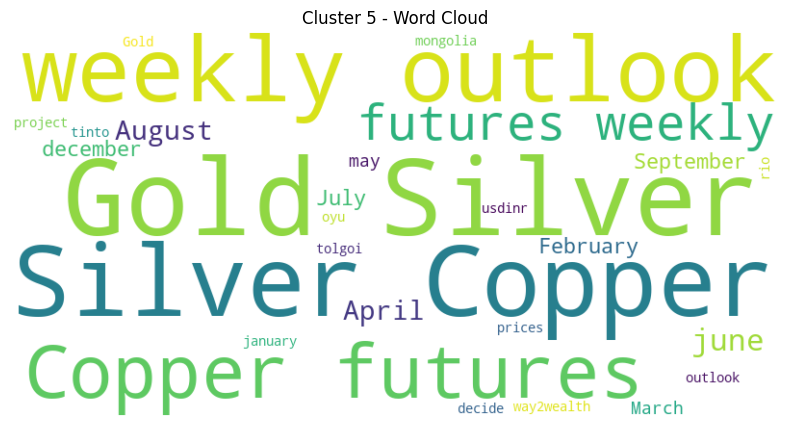


=== Cluster 6 (Size: 41) ===

Sample Headlines:
- cboe gold index closes at 84.2, up 4%
- cboe gold index closes at 141.18 points, down 0.4%
- cboe gold index up 2.9% to end at 92.91, up 4.2% on wk
- cboe gold index closes at 131.17, down 0.6%
- Profit-booking pulls gold futures down to Rs 30,505 

Top 10 Terms:
- gold (count: 41)
- cboe (count: 26)
- index (count: 26)
- down (count: 15)
- futures (count: 15)
- closes (count: 8)
- pulls (count: 6)
- falls (count: 5)
- highest (count: 4)
- since (count: 4)


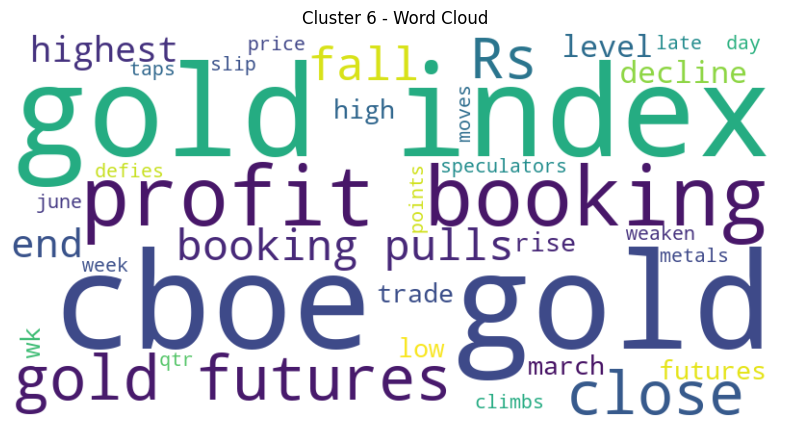


=== Cluster 7 (Size: 60) ===

Sample Headlines:
- spot gold quoted at $404.10 in asia
- spot gold quoted at $394.80, up 0.05% from ny
- spot gold quoted at $597.90 in asia trade
- spot gold quoted at $552.50 in asia trade
- spot gold quoted at $471.40 in asia trade

Top 10 Terms:
- spot (count: 60)
- gold (count: 60)
- quoted (count: 56)
- asia (count: 55)
- trade (count: 51)
- from (count: 6)
- down (count: 4)
- prices (count: 2)
- rise (count: 2)
- early (count: 1)


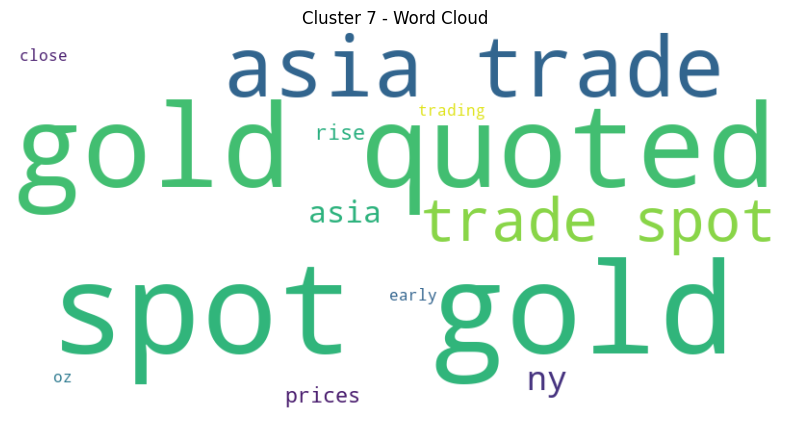


=== Cluster 8 (Size: 98) ===

Sample Headlines:
- Gold futures up at Rs 30,226/10 gm
- Gold futures down at Rs 30,383 per 10 gm
- Gold futures rise to Rs 29,000 per 10 gm
- MCX gold may touch Rs 30,080 per 10 gm
- Gold futures rise to Rs 26,502 per 10 gm

Top 10 Terms:
- gold (count: 98)
- per (count: 93)
- futures (count: 89)
- down (count: 27)
- rise (count: 17)
- decline (count: 6)
- climb (count: 5)
- jump (count: 5)
- mcx (count: 3)
- high (count: 3)


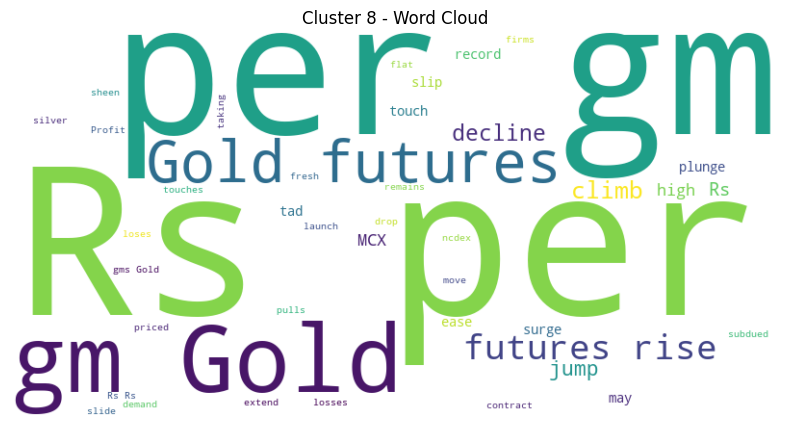


=== Cluster 9 (Size: 15) ===

Sample Headlines:
- philadelphia gold/silver index ends at 99.96, up 0.5% on day
- philadelphia gold/silver index up 2% to end at 114.47
- philadelphia gold/silver index ends near one-week high
- philadelphia gold/silver index closes at a two-month high
- philadelphia gold/silver index closes at 91.13, up 0.4%

Top 10 Terms:
- philadelphia (count: 15)
- index (count: 15)
- closes (count: 4)
- falls (count: 4)
- close (count: 4)
- ends (count: 3)
- end (count: 2)
- high (count: 2)
- down (count: 2)
- day (count: 1)


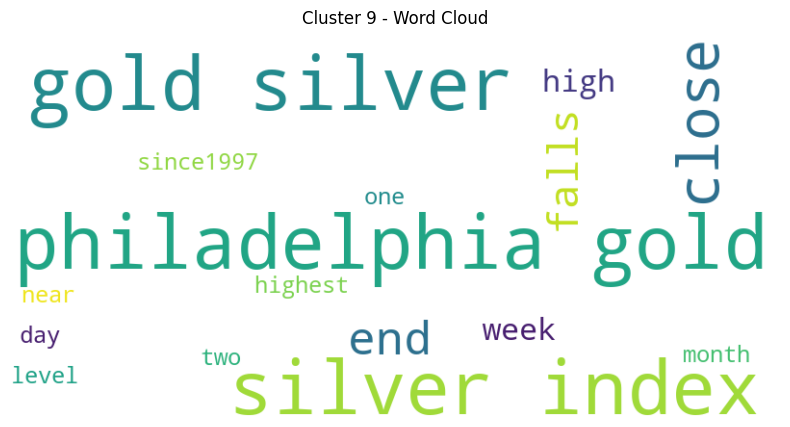


=== Cluster 10 (Size: 55) ===

Sample Headlines:
- gold stays lower after fed's beige book
- gold settles lower, extends loss after fed beige book
- amex gold bugs index ends at a record 393.28, up 4.6%
- amex gold bugs index falls 6.7% to close at 359.4
- winning week for gold leaves bugs hopeful, wary

Top 10 Terms:
- gold (count: 54)
- bugs (count: 33)
- index (count: 26)
- amex (count: 25)
- beige (count: 18)
- book (count: 18)
- fed (count: 16)
- after (count: 15)
- down (count: 13)
- ends (count: 11)


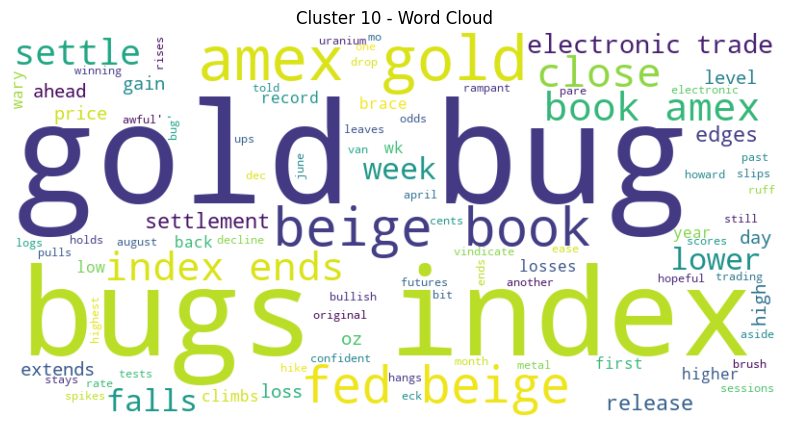


=== Cluster 11 (Size: 42) ===

Sample Headlines:
- spot gold quoted at $421.30, down 40c from new york
- spot gold quoted at $393.50, down 40c from new york
- spot gold quoted at $422.10, down 30c from new york
- spot gold quoted at $403.60, unchanged from new york
- spot gold quoted at $417.30, down 40c from new york

Top 10 Terms:
- spot (count: 42)
- gold (count: 42)
- quoted (count: 42)
- from (count: 42)
- new (count: 42)
- york (count: 42)
- down (count: 26)
- cents (count: 6)
- unchanged (count: 3)


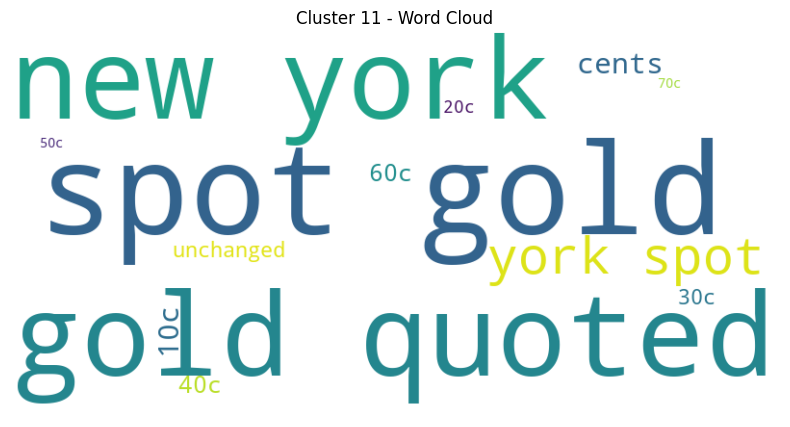


=== Cluster 12 (Size: 14) ===

Sample Headlines:
- Gold futures fall to Rs 31,144 per 10 gm
- Gold futures fall to Rs 31,167 per 10 gm
- Gold futures fall to Rs 27,861 per 10 gm
- Gold futures fall to Rs 31,395 per 10 gm
- Gold futures fall to Rs Rs 30,230 per 10 gm

Top 10 Terms:
- gold (count: 14)
- per (count: 13)
- futures (count: 12)
- fall (count: 12)
- falls (count: 2)
- sees (count: 1)
- biggest (count: 1)
- weakening (count: 1)
- trend (count: 1)


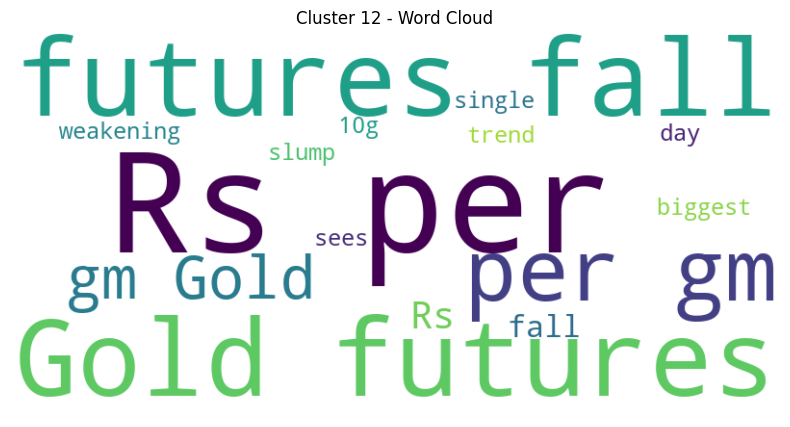


=== Cluster 13 (Size: 17) ===

Sample Headlines:
- philadelphia gold & silver index falls 2.2%
- philadelphia gold and silver index down 3.4% for week
- philadelphia gold & silver index rises 2.4%
- philadelphia gold & silver index falls 2.7%
- philadelphia gold & silver index climbs 1.8%

Top 10 Terms:
- philadelphia (count: 17)
- gold (count: 17)
- silver (count: 17)
- index (count: 17)
- falls (count: 4)
- rises (count: 4)
- and (count: 3)
- down (count: 3)
- for (count: 2)
- week (count: 2)


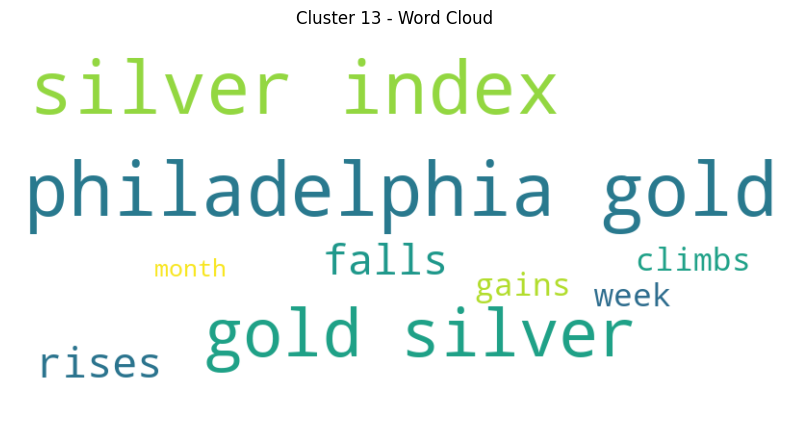

In [ ]:
from collections import Counter


def analyze_clusters(df, n_samples=5):
    # Group by cluster
    clusters = df.groupby("cluster")

    for cluster_id, group in clusters:
        if cluster_id == -1:
            print("\n=== Noise/Outliers ===")
        else:
            print(f"\n=== Cluster {cluster_id} (Size: {len(group)}) ===")

        # Print sample headlines
        print("\nSample Headlines:")
        for headline in group["News"].head(n_samples):
            print(f"- {headline}")

        # Show most frequent words
        words = " ".join(group["News"]).lower().split()
        common_words = [
            word for word in words if word.isalpha() and len(word) > 2
        ]  # Filter short/non-alphabetic
        word_counts = Counter(common_words).most_common(10)

        print("\nTop 10 Terms:")
        for word, count in word_counts:
            print(f"- {word} (count: {count})")

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
            " ".join(group["News"])
        )
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Cluster {cluster_id} - Word Cloud")
        plt.show()


# Run analysis
analyze_clusters(gold_df)